# **Book Summary vs. Book Cover:** Is it easier to predict a book genre based on the book summary or the book cover?

Author: Alyssa Hayo

Semester: Spring 2021

School: UMBC

Class: DATA606 - Capstone

In [ ]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import json
import math

import os
import codecs
from argparse import ArgumentParser
from urllib import request
from tqdm import trange
from joblib import Parallel, delayed

import requests, zipfile, io
import tarfile
import csv
from tqdm import tqdm

## 1. Book Summary Data

### 1.1 Download the Data

In [ ]:
download_url = "http://www.cs.cmu.edu/~dbamman/data/booksummaries.tar.gz"
r = requests.get(download_url)

tar_bytes = io.BytesIO(r.content)
tf = tarfile.open(mode = 'r', fileobj=tar_bytes)
tf.extractall()

In [ ]:
#code adapted from: https://www.kaggle.com/iamhungundji/book-summary-genre-prediction/notebook

data = []

with open("booksummaries/booksummaries.txt", 'r', encoding="utf-8") as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

16559it [00:00, 40865.95it/s]


In [ ]:
#code adapted from: https://www.kaggle.com/iamhungundji/book-summary-genre-prediction/notebook
wiki_id = []
freebase_id = []
book_title = []
book_author = []
publication_date = []
genre = []
summary = []

for i in tqdm(data):
    wiki_id.append(i[0])
    freebase_id.append(i[1])
    book_title.append(i[2])
    book_author.append(i[3])
    publication_date.append(i[4])
    genre.append(i[5])
    summary.append(i[6])

books_summary = pd.DataFrame(data, columns = {'wiki_id': wiki_id, 'freebase_id': freebase_id, 
                      'book_title': book_title, 'book_author': book_author,
                      'publication_date': publication_date, 'genre': genre, 
                      'summary': summary})
books_summary.head()

100%|██████████████████████████████████████████████████████████████████████| 16559/16559 [00:00<00:00, 1037563.75it/s]


wiki_id freebase_id                                 book_title  \
0     620     /m/0hhy                                Animal Farm   
1     843     /m/0k36                         A Clockwork Orange   
2     986     /m/0ldx                                 The Plague   
3    1756     /m/0sww  An Enquiry Concerning Human Understanding   
4    2080     /m/0wkt                       A Fire Upon the Deep   

       book_author publication_date  \
0    George Orwell       1945-08-17   
1  Anthony Burgess             1962   
2     Albert Camus             1947   
3       David Hume                    
4     Vernor Vinge                    

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                      
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

In [ ]:
books_summary.describe()

wiki_id freebase_id book_title book_author publication_date  genre  \
count     16559       16559      16559       16559            16559  16559   
unique    16559       16559      16277        4715             2640   2155   
top     7943220  /m/04163m0    Nemesis                                       
freq          1           1          6        2382             5610   3718   

                                     summary  
count                                  16559  
unique                                 16532  
top      ~Plot outline description~ --> <!--  
freq                                      13

In [ ]:
books_summary.shape

(16559, 7)

Data is downloaded! We have 7 columns and 16559 rows.

### 1.2 Clean the Data

#### 1.2.1 What do our genres look like?

In [ ]:
print(books_summary['genre'].describe())
print()
print(books_summary['genre'].value_counts())

count     16559
unique     2155
top            
freq       3718
Name: genre, dtype: object

                                                                                                                                                                                                                              3718
{"/m/05hgj": "Novel"}                                                                                                                                                                                                          839
{"/m/06n90": "Science Fiction", "/m/014dfn": "Speculative fiction"}                                                                                                                                                            567
{"/m/06n90": "Science Fiction"}                                                                                                                                                                                                526


Need to break the genres out into a readable list.

In [ ]:
#next 3 blocks of code taken from https://www.kaggle.com/iamhungundji/book-summary-genre-prediction/notebook
books_summary.drop(books_summary[books_summary['genre']==''].index, inplace=True)
books_summary[books_summary['genre']=='']

Empty DataFrame
Columns: [wiki_id, freebase_id, book_title, book_author, publication_date, genre, summary]
Index: []

In [ ]:
genres = []
for i in books_summary['genre']:
    genres.append(list(json.loads(i).values()))
books_summary['genre_new'] = genres

In [ ]:
# How many genres are there?
all_genres = sum(genres,[])
len(set(all_genres))

227

In [ ]:
books_summary.sample(5)

wiki_id freebase_id                   book_title       book_author  \
14798  25508269  /m/09rs4qx         Rides a Dread Legion  Raymond E. Feist   
10468  12735525  /m/02x2m_8          The Seventh Crystal      Gary Paulsen   
16199  32176086  /m/0gx_q_x            Princess of Glass                     
6835    5713763   /m/0f0qxw  Alanna: The First Adventure     Tamora Pierce   
11986  16799556  /m/0406lbs                   Revelation      C. J. Sansom   

      publication_date                                              genre  \
14798                                            {"/m/01hmnh": "Fantasy"}   
10468       1996-07-01            {"/m/03mfnf": "Young adult literature"}   
16199             2010                           {"/m/01hmnh": "Fantasy"}   
6835           1983-09  {"/m/014dfn": "Speculative fiction", "/m/01hmn...   
11986       2008-04-04                      {"/m/0lsxr": "Crime Fiction"}   

                                                 summary  \
14798   Ten years after the cataclysmic events of Wra...   
10468   The story is about Chris Masters who is havin...   
16199   Three years after being freed from the curse ...   
6835    Alanna of Trebond and her twin brother Thom m...   
11986   The plot centres around the challenges of pos...   

                                     genre_new  
14798                                [Fantasy]  
10468                 [Young adult literature]  
16199                                [Fantasy]  
6835   [Speculative fiction, Fantasy, Fiction]  
11986                          [Crime Fiction]

#### 1.2.2 Get the count of each genre

In [ ]:
# Create a list of all of the genres
genre_list = []

for i, row in books_summary.iterrows():
  genres = row['genre_new']
  for item in range(len(genres)):
    genre_list.append(genres[item])

In [ ]:
# Grabbed code from: https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/

def CountFrequency(my_list):
  # Create an empty dictionary
  freq = {}
  for item in my_list:
    if (item in freq):
      freq[item] += 1
    else:
      freq[item] = 1

  return freq

In [ ]:
genre_count = CountFrequency(genre_list)

In [ ]:
# View the genre and their count
for key,value in genre_count.items():
    print(key,value)

Roman à clef 29
Satire 123
Children's literature 2122
Speculative fiction 4314
Fiction 4747
Science Fiction 2870
Novella 87
Utopian and dystopian fiction 67
Existentialism 8
Absurdist fiction 29
Novel 2463
Hard science fiction 25
Fantasy 2413
War novel 87
Bildungsroman 42
Religious text 4
Picaresque novel 18
Gothic fiction 112
Horror 511
Invasion literature 4
Mystery 1396
Epistolary novel 30
Parody 15
Psychological novel 26
Farce 4
Philosophy 47
Science 22
Dystopia 127
Detective fiction 341
Suspense 765
Historical fiction 388
Adventure novel 330
Humour 62
Historical novel 654
Sea story 4
Cyberpunk 16
Business 16
Non-fiction 230
Economics 13
Anthropology 4
Sociology 31
Romance novel 435
Poetry 28
Chivalric romance 15
High fantasy 66
Time travel 20
Scientific romance 14
Crime Fiction 753
Juvenile fantasy 2
Religion 16
Inspirational 10
Short story 78
Techno-thriller 59
Thriller 568
Young adult literature 825
Drama 29
Play 9
Albino bias 2
Computer Science 1
Reference 38
Supernatural 4
Come

In [ ]:
# How many genres are there? - Confirm it is still the same as earlier, it should be 227.
print(len(genre_count))

227


For each genre for the book, creat a new row with only one genre.

In [ ]:
# Create a blank dataframe to append the new rows to
blank_df = pd.DataFrame(columns=['wiki_id','freebase_id','book_title','book_author','publication_date','genre_new','summary'])

# If there are multiple genres, make a new row for each genre
for i, row in books_summary.iterrows():
  genres = row['genre_new']
  for x in range(len(genres)):
    genre_name = genres[x]
    new_row = [row['wiki_id'],row['freebase_id'],row['book_title'],row['book_author'],row['publication_date'],genre_name, row['summary']]
    new_df = pd.DataFrame([new_row], columns=['wiki_id','freebase_id','book_title','book_author','publication_date','genre_new','summary'])
    blank_df = blank_df.append(new_df)

In [ ]:
books_summary.sample(5)

wiki_id freebase_id                                   book_title  \
3461    2279714   /m/070g3l                          Becoming Madame Mao   
4956    3753262   /m/09z4nb  The Sentimental Agents in the Volyen Empire   
14477  24322212  /m/047m6rz                             The Quest Begins   
7877    7267464  /m/025xr43                              A Thief of Time   
12654  18686774  /m/04gtfng                            Assignment:Murder   

           book_author publication_date  \
3461        Anchee Min             2001   
4956     Doris Lessing             1983   
14477   Cherith Baldry       2008-05-27   
7877    Tony Hillerman             1988   
12654  Donald Hamilton             1956   

                                                   genre  \
3461                    {"/m/0hwxm": "Historical novel"}   
4956                     {"/m/06n90": "Science Fiction"}   
14477  {"/m/01hmnh": "Fantasy", "/m/014dfn": "Specula...   
7877   {"/m/02n4kr": "Mystery", "/m/014dfn": "Specula...   
12654                          {"/m/01jfsb": "Thriller"}   

                                                 summary  \
3461    Madame Mao was born to a very poor family aro...   
4956    The Volyen Empire is a relatively weak inters...   
14477   The novel follows the adventure of four bears...   
7877    Ellie Friedman-Bernal is suspected of selling...   
12654   Dr. James Gregory, a scientist at a secret la...   

                                               genre_new  
3461                                  [Historical novel]  
4956                                   [Science Fiction]  
14477  [Fantasy, Speculative fiction, Young adult lit...  
7877   [Mystery, Speculative fiction, Fiction, Suspense]  
12654                                         [Thriller]

In [ ]:
# let remove genres from the dataframe if the number of books in that genre is less than 500
asd = blank_df.genre_new.value_counts()
general_list = asd[blank_df.genre_new.value_counts()<500].index.to_list()
blank_df['dummy'] = blank_df.genre_new.apply(lambda x: 1 if x in general_list else 0)

df = blank_df[blank_df.dummy==0]
df = df.reset_index()
df.sample(3)

index   wiki_id freebase_id     book_title      book_author  \
6240       0   2220502   /m/06wzby         Lasher        Anne Rice   
22161      0  20166689  /m/04ydkml      Darkhouse                    
7720       0   3021563   /m/08l29r  The Sheep-Pig  Dick King-Smith   

      publication_date genre_new  \
6240        1993-09-12   Fantasy   
22161                   Thriller   
7720        1983-11-12   Fiction   

                                                 summary  dummy  
6240    The novel begins shortly after the mysterious...      0  
22161   The novel kicks off in New York City with the...      0  
7720    The plot revolves around a young pig, won at ...      0

In [ ]:
df.genre_new.value_counts()

Fiction                   4747
Speculative fiction       4314
Science Fiction           2870
Novel                     2463
Fantasy                   2413
Children's literature     2122
Mystery                   1396
Young adult literature     825
Suspense                   765
Crime Fiction              753
Historical novel           654
Thriller                   568
Horror                     511
Name: genre_new, dtype: int64

In [ ]:
df.shape

(24401, 9)

#### 1.2.3 Genre mapping 

I'm going to now condense the remaining 13 genres to 7 genres to match the amount of genres I'll be using for my book covers data.

The genres I'll be using and their mapping are:


*   Fiction
*   Speculative fiction
*   Science Fiction
*   Novel
*   Fantasy
*   Mystery: Mystery, Suspense, Thriller, Horror
*   Other: Children's literature, Young adult literature, Historical novel, Crime Fiction



In [ ]:
df.loc[df.genre_new == 'Suspense','genre_new'] = 'Mystery'
df.loc[df.genre_new == 'Thriller','genre_new'] = 'Mystery'
df.loc[df.genre_new == 'Horror','genre_new'] = 'Mystery'
df.loc[df.genre_new == 'Children\'s literature','genre_new'] = 'Other'
df.loc[df.genre_new == 'Young adult literature','genre_new'] = 'Other'
df.loc[df.genre_new == 'Historical novel','genre_new'] = 'Other'
df.loc[df.genre_new == 'Crime Fiction','genre_new'] = 'Other'

In [ ]:
df.columns

Index(['index', 'wiki_id', 'freebase_id', 'book_title', 'book_author',
       'publication_date', 'genre_new', 'summary', 'dummy'],
      dtype='object')

In [ ]:
df.rename(columns=({'genre_new':'genre'}),inplace=True)
df = df[['wiki_id', 'book_title', 'book_author', 'publication_date', 'genre',
       'summary']]
df.sample(3)

wiki_id                       book_title   book_author  \
5939   2043293          The Boy Who Kicked Pigs     Tom Baker   
16660  9461165                  Duty and Desire  Pamela Aidan   
7966   3158342  The Confusions of Young Törless  Robert Musil   

      publication_date  genre  \
5939              1999  Other   
16660             2004  Other   
7966              1906  Novel   

                                                 summary  
5939    The novel begins by announcing that today wil...  
16660   In relation to Pride and Prejudice, on which ...  
7966    Three students of an Austrian boarding school...

In [ ]:
df.genre.value_counts()

Fiction                4747
Other                  4354
Speculative fiction    4314
Mystery                3240
Science Fiction        2870
Novel                  2463
Fantasy                2413
Name: genre, dtype: int64

#### 1.2.4 Rest of data cleaning

In [ ]:
# download stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
summary_data = df.copy()

# drop null values
summary_data = summary_data.dropna()

# convert summaries to lower case
summary_data['summary'] = summary_data['summary'].str.lower()

# remove stop words - adatped from: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
summary_data['summary_old'] = summary_data['summary']
summary_data['summary'] = summary_data['summary_old'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# remove punctuation - adapted from: https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
summary_data['summary'] = summary_data['summary'].str.replace('[^\w\s]','')

summary_data.sample(3)

<ipython-input-236-87237536c8d5>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  summary_data['summary'] = summary_data['summary'].str.replace('[^\w\s]','')


wiki_id            book_title book_author publication_date    genre  \
6337    2270992  Servant of the Bones   Anne Rice             1996  Fiction   
16814   9648897          Without Fail   Lee Child       2002-05-09  Mystery   
19883  14256309                  Jinx   Meg Cabot       2007-07-31    Other   

                                                 summary  \
6337   azriel telling story transformation subsequent...   
16814  reacher arrives atlantic city new jersey hitch...   
19883  jean jinx honeychurch sixteenyearold girl iowa...   

                                             summary_old  
6337    azriel is telling the story of his transforma...  
16814   reacher arrives in atlantic city, new jersey,...  
19883   jean "jinx" honeychurch is a sixteen-year-old...

### 1.3 Exploratory Data Analysis

Lets create word clouds for each genre.

In [ ]:
from collections import Counter

def get_freq_dist(df):
    '''
    Processes a pandas DataFrame to concatenate every book summary into a flattened list of words.
    Once flattened we create the frequency distribution of the entirety of the DataFrame 
    '''
    full_summary = df['summary'].values
    flat_summary = " ".join([str(item) for item in full_summary])
    list_summary = flat_summary.split(" ")
    freqDist = Counter(list_summary)
    
    return freqDist

In [ ]:
freq_dist_fiction = get_freq_dist(summary_data[summary_data['genre']=="Fiction"])
freq_dist_other = get_freq_dist(summary_data[summary_data['genre']=="Other"])
freq_dist_spec_fic = get_freq_dist(summary_data[summary_data['genre']=="Speculative fiction"])
freq_dist_mystery = get_freq_dist(summary_data[summary_data['genre']=="Mystery"])
freq_dist_novel = get_freq_dist(summary_data[summary_data['genre']=="Novel"])
freq_dist_fantasy = get_freq_dist(summary_data[summary_data['genre']=="Fantasy"])
freq_dist_sci_fi = get_freq_dist(summary_data[summary_data['genre']=="Science Fiction"])

In [ ]:
freq_list_fiction = sorted(freq_dist_fiction.items(), key=lambda item: item[1], reverse=True)
freq_list_fantasy = sorted(freq_dist_fantasy.items(), key=lambda item: item[1], reverse=True)
freq_list_spec_fic = sorted(freq_dist_spec_fic.items(), key=lambda item: item[1], reverse=True)
freq_list_mystery = sorted(freq_dist_mystery.items(), key=lambda item: item[1], reverse=True)
freq_list_novel = sorted(freq_dist_novel.items(), key=lambda item: item[1], reverse=True)
freq_list_other = sorted(freq_dist_other.items(), key=lambda item: item[1], reverse=True)
freq_list_sci_fi = sorted(freq_dist_sci_fi.items(), key=lambda item: item[1], reverse=True)

# test one
freq_list_fantasy

[('one', 3431),
 ('back', 2138),
 ('him', 2121),
 ('find', 2109),
 ('time', 2071),
 ('also', 2046),
 ('two', 1948),
 ('', 1840),
 ('world', 1778),
 ('however', 1702),
 ('new', 1685),
 ('help', 1638),
 ('king', 1591),
 ('life', 1502),
 ('finds', 1477),
 ('tells', 1465),
 ('first', 1460),
 ('her', 1439),
 ('book', 1425),
 ('city', 1402),
 ('way', 1382),
 ('magic', 1283),
 ('later', 1281),
 ('them', 1281),
 ('death', 1251),
 ('story', 1241),
 ('man', 1224),
 ('takes', 1221),
 ('go', 1219),
 ('people', 1211),
 ('home', 1190),
 ('father', 1177),
 ('take', 1157),
 ('return', 1152),
 ('power', 1145),
 ('named', 1126),
 ('it', 1104),
 ('begins', 1069),
 ('must', 1036),
 ('would', 1017),
 ('years', 1016),
 ('escape', 1016),
 ('old', 1008),
 ('kill', 1008),
 ('away', 1000),
 ('house', 998),
 ('killed', 983),
 ('group', 950),
 ('battle', 946),
 ('become', 937),
 ('make', 937),
 ('eventually', 933),
 ('soon', 925),
 ('called', 924),
 ('night', 920),
 ('get', 916),
 ('three', 904),
 ('many', 903),


In [ ]:
freq_list_fiction_wc = { k: v for k, v in sorted(freq_dist_fiction.items(), key=lambda item: item[1], reverse=True)}
freq_list_fantasy_wc = { k: v for k, v in sorted(freq_dist_fantasy.items(), key=lambda item: item[1], reverse=True)}
freq_list_spec_fic_wc = { k: v for k, v in sorted(freq_dist_spec_fic.items(), key=lambda item: item[1], reverse=True)}
freq_list_mystery_wc = { k: v for k, v in sorted(freq_dist_mystery.items(), key=lambda item: item[1], reverse=True)}
freq_list_novel_wc = { k: v for k, v in sorted(freq_dist_novel.items(), key=lambda item: item[1], reverse=True)}
freq_list_other_wc = { k: v for k, v in sorted(freq_dist_other.items(), key=lambda item: item[1], reverse=True)}
freq_list_sci_fi_wc = { k: v for k, v in sorted(freq_dist_sci_fi.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
!pip install wordcloud

You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


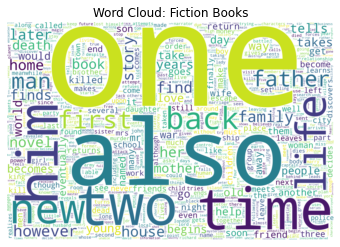

In [ ]:
from wordcloud import WordCloud

# for Fiction Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_fiction_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Fiction Books')
plt.show()

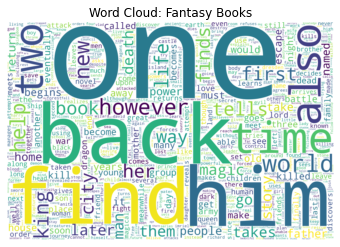

In [ ]:
# for Fantasy Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_fantasy_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Fantasy Books')
plt.show()

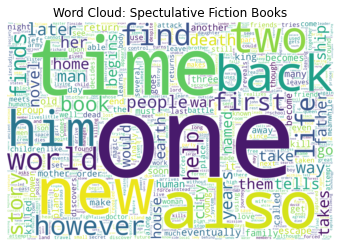

In [ ]:
# for Spectulative Fiction Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_spec_fic_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Spectulative Fiction Books')
plt.show()

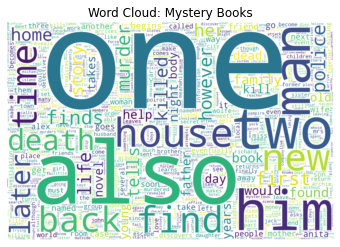

In [ ]:
# for Mystery Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_mystery_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Mystery Books')
plt.show()

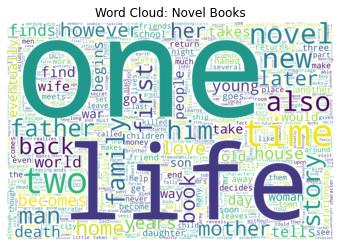

In [ ]:
# for Novel Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_novel_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Novel Books')
plt.show()

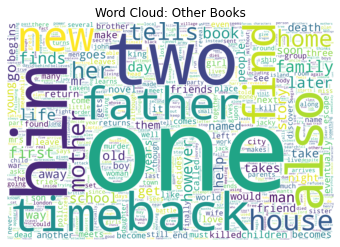

In [ ]:
# for Other Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_other_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Other Books')
plt.show()

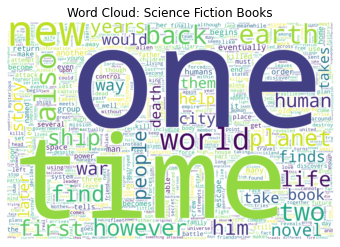

In [ ]:
# for Science Fiction Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_sci_fi_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Science Fiction Books')
plt.show()

### 1.4 Neural Networks
- Build Dataset classes and vocabularies
- Simple RNN

#### 1.4.1 Build Dataset classes and vocabularies

In [ ]:
#import statements
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Using the Vocabulary Class from https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html

class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {self.PAD_token: "PAD", self.SOS_token: "SOS", self.EOS_token: "EOS"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0
    
    def __len__(self):
      return self.num_words

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word.get(index)

    def to_index(self, word):
        return self.word2index.get(word)

In [ ]:
# Create Class - based off of Modern Practical Deep Learning (Raff's Class)
class BooksDataset(Dataset):
    
    def __init__(self, reviews_dict, alphabet):
        
        self.data = reviews_dict
        self.labels = [x for x in reviews_dict.keys()]
        self.alphabet = alphabet
        
    def __len__(self):
        return sum([len(x) for x in self.data.values()])
    
    # Return item from the dataset
    def __getitem__(self, idx):
        label = 0
        while idx >= len(self.data[self.labels[label]]):
            idx -= len(self.data[self.labels[label]])
            label += 1
        name = self.data[self.labels[label]][idx]
        
        
        
        label_vec = torch.zeros((1), dtype=torch.long)
        label_vec[0] = label
        
        return self.sentence2InputVec(name), label
    
    def sentence2InputVec(self, sentence):
      T = len(sentence.split(' '))
      sent_vec = torch.zeros((T), dtype=torch.long)
      for pos in range(T):
        if self.alphabet.to_index(sentence.split(' ')[pos]) is None:
          print(sentence.split(' '))
          print(pos)
          print(sentence.split(' ')[pos])
        sent_vec[pos] = self.alphabet.to_index(sentence.split(' ')[pos])
            
      return sent_vec


In [ ]:
# Create Vocabulary for Genres
vocab_list_g = Vocabulary("Vocab for Genres")

In [ ]:
# Add all of the words to the Vocabulary
for i, row in summary_data.iterrows():
    summary = row['summary']
    vocab_list_g.add_sentence(summary)

In [ ]:
# Test to make sure vocabulary works
sent_tkns = []
sent_idxs = []

for i, row in summary_data.iterrows():
  for word in row['summary'].split(' '):
    sent_tkns.append(word)
    sent_idxs.append(vocab_list_g.to_index(word))

print(sent_tkns[:10])
print(sent_idxs[:10])

['old', 'major', 'old', 'boar', 'manor', 'farm', 'calls', 'animals', 'farm', 'meeting']
[3, 4, 3, 5, 6, 7, 8, 9, 7, 10]


In [ ]:
# Put everything in a list with the format: [[summary_1, q_group_1],[summary_2, q_group_2], ... ,[summary_n, q_group_n]]

g_label = []
for i,row in summary_data.iterrows():
  g_label.append([row['summary'],row['genre']])

# Check to see if it worked
for i in range(5):
  print(g_label[i])

['old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies two young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt seven commandments animalism important is all animals equal snowball attempts teach animals reading writing food plentiful farm runs smoothly pigs elevate positions leadership set aside special food items ostensibly personal health napoleon takes pups farm dogs trains privately napoleon snowball struggle leadership snowball announces plans build windmill napoleon dogs chase snowball away declares leader napoleon enacts changes governance structure farm replacing meetings committee pigs run farm using young pig named squealer mouthpiece napoleon claims credit windmill idea animals work harder promise easier lives windmill violent storm animals find windmill annihilated napoleon squealer convi

In [ ]:
# Convert all the words to the index: ["This is a sentence."]->[8,19,20,25]

sent_idx_test_all = []

for i in range(len(g_label)):
  sent_tkns = []
  sent_idxs = []
  for word in g_label[i][0].split(' '):
    sent_tkns.append(word)
    sent_idxs.append(vocab_list_g.to_index(word))
  sent_idx_test_all.append(tuple([torch.FloatTensor(sent_idxs),g_label[i][1]]))


In [ ]:
# Testing words to index
sent_idx_test_all[0]

(tensor([  3.,   4.,   3.,   5.,   6.,   7.,   8.,   9.,   7.,  10.,  11.,  12.,
          13.,  14.,   9.,  15.,  16.,  17.,  18.,   4.,  19.,  20.,  21.,  22.,
          23.,  24.,  25.,  26.,  27.,  28.,  29.,   9.,  30.,  31.,  32.,  33.,
          34.,  35.,   7.,  36.,  37.,   7.,  38.,  39.,  40.,  41.,  42.,  43.,
          44.,   9.,  45.,  23.,  46.,  47.,   9.,  48.,  49.,  50.,  51.,   7.,
          52.,  53.,  22.,  54.,  55.,  56.,  57.,  58.,  59.,  50.,  60.,  61.,
          62.,  63.,  24.,  64.,  65.,   7.,  66.,  67.,  68.,  24.,  23.,  69.,
          56.,  23.,  70.,  71.,  72.,  73.,  24.,  66.,  74.,  23.,  75.,  76.,
          77.,  24.,  78.,  79.,  80.,  81.,   7.,  82.,  83.,  84.,  22.,  85.,
           7.,  86.,  21.,  87.,  88.,  89.,  90.,  24.,  91.,  92.,  73.,  93.,
           9.,  94.,  95.,  96.,  97.,  98.,  73.,  99., 100.,   9., 101.,  73.,
         102.,  24.,  89., 103.,   9.,  23., 104., 105., 106., 107., 108., 109.,
         110., 111., 112.,  

In [ ]:
# Pulled code from: https://datascience.stackexchange.com/questions/32328/export-pandas-to-dictionary-by-combining-multiple-row-values
g_dict = {}
for i in summary_data['genre'].unique():
    g_dict[i] = [summary_data['summary'][j] for j in summary_data[summary_data['genre']==i].index]

In [ ]:
# check to see the genres are pulled correctly
g_dict.keys()

dict_keys(['Other', 'Speculative fiction', 'Fiction', 'Science Fiction', 'Novel', 'Fantasy', 'Mystery'])

In [ ]:
# view all the summaries in the "Fiction" category
g_dict['Fiction']

['old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies two young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt seven commandments animalism important is all animals equal snowball attempts teach animals reading writing food plentiful farm runs smoothly pigs elevate positions leadership set aside special food items ostensibly personal health napoleon takes pups farm dogs trains privately napoleon snowball struggle leadership snowball announces plans build windmill napoleon dogs chase snowball away declares leader napoleon enacts changes governance structure farm replacing meetings committee pigs run farm using young pig named squealer mouthpiece napoleon claims credit windmill idea animals work harder promise easier lives windmill violent storm animals find windmill annihilated napoleon squealer convi

In [ ]:
# Create dataset based off of Books Class
dataset_genres = BooksDataset(g_dict, vocab_list_g)

#### 1.4.2 Build Simple RNN

In [ ]:
#define the class LastTimeStep (taken from Raff's Class)
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tuple (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]

        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [ ]:
train_size_g = int(len(dataset_genres)*0.8)
test_size_g = len(dataset_genres)-train_size_g

train_data_g, test_data_g = torch.utils.data.random_split(dataset_genres, [train_size_g, test_size_g])


train_loader_genres = DataLoader(train_data_g, batch_size=1, shuffle=True)
test_loader_genres = DataLoader(test_data_g, batch_size=1, shuffle=False)

In [ ]:
print("Num classes in genre:", summary_data['genre'].nunique())
print("Length of genres vocab:", len(vocab_list_g))

Num classes in genre: 7
Length of genres vocab: 126431


In [ ]:
#taken from mpdl.py - Raff's Class
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
def simple_rnn_model(D = 32, batch_size = 126431, hidden_nodes = 64):
  model = nn.Sequential(
    nn.Embedding(batch_size, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, 7), #(B, D) -> (B, classes)
  ) 
  return model

In [ ]:
#simple RNN for genres

loss_func = nn.CrossEntropyLoss()

simple_rnn_results_genres = train_simple_network(simple_rnn_model(), loss_func, 
                                                  train_loader_genres, 
                                                  val_loader=test_loader_genres, 
                                                  score_funcs={'Accuracy': accuracy_score}, 
                                                  device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/19520 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

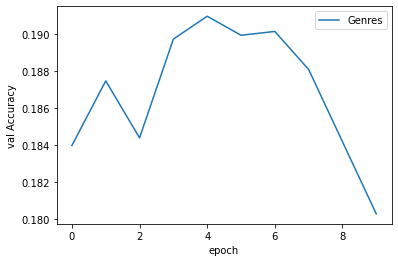

In [ ]:
import seaborn as sns

sns.lineplot(x='epoch', y='val Accuracy', data=simple_rnn_results_genres, label='Genres')

In [ ]:
simple_rnn_results_genres

NameError: ignored

#### 1.4.3 Gated Recurrent Unit (GRU)

In [ ]:
!pip install  torchtext==0.5.0
!pip install  sentencepiece
!pip install tensorflow

You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached google_auth-1.30.0-py2.py3-none-any.whl (146 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
Using legacy 'setup.py install' for wrapt, since package 'wheel' is not installed.
Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Ethan\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
# Code taken from DATA690 - Modern Deep Learning Class
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(42)

Store the vocab size, class size, and padding index. Need to increase the voacb size by 1 so I can add a padding value. Will store the padding as padding_idx so that can be placed at the end of the batches to make them the same length.

In [ ]:
VOCAB_SIZE_G = len(vocab_list_g)
NUM_CLASS_G = summary_data['genre'].nunique()

padding_idx = VOCAB_SIZE_G
VOCAB_SIZE_G += 1

Figure out what the longest sequence is and then pad to the right of each item, making them all the same length. This allows us to stack them into a single tensor.

In [ ]:
#taken from Modern Practical Deep Learning
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch. 
    Also, re-order so that the values are returned (input, label)
    """
    texts = [z[0] for z in batch]
    labels = [z[1] for z in batch]
    
    
    max_len = max([text.size(0) for text in texts])
    
    PAD = padding_idx
    
    texts = [F.pad(text, (0,max_len-text.size(0)), value=PAD) for text in texts]
    
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
    
    return x, y

In [ ]:
B = 16
embed_dim = 128
epochs = 10

In [ ]:
# Genres dataset
gru_train_loader_genre = DataLoader(train_data_g, batch_size = B, shuffle=True, collate_fn=pad_batch)
gru_test_loader_genre = DataLoader(test_data_g, batch_size=B, shuffle=False, collate_fn=pad_batch)

In [ ]:
#taken from mpdl.py - Modern Practical Deep Learning Class
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return obj

In [ ]:
#taken from mpdl.py - Modern Practical Deep Learning Class
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            if isinstance(labels, torch.Tensor):
                batch_size = labels.shape[0]
            elif isinstance(inputs, torch.Tensor):
                batch_size = inputs.shape[0]
            else:
                batch_size = len(inputs)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            try:
                results["train " + name].append( score_func(y_true, y_pred) )
            except:
                results["train " + name].append("NaN")
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if isinstance(labels, torch.Tensor):
                    batch_size = labels.shape[0]
                elif isinstance(inputs, torch.Tensor):
                    batch_size = inputs.shape[0]
                else:
                    batch_size = len(inputs)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                try:
                    results["val " + name].append( score_func(y_true, y_pred) )
                except:
                    results["val " + name].append( "NaN" )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [ ]:
# Genres
gru_g = nn.Sequential(
  nn.Embedding(VOCAB_SIZE_G, embed_dim), #(B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS_G), #(B, D*2) -> (B, classes)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()

gru_results_g = train_network(gru_g, loss_func, gru_train_loader_genre, val_loader=gru_test_loader_genre,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1220 [00:00<?, ?it/s]

Look at the results.

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

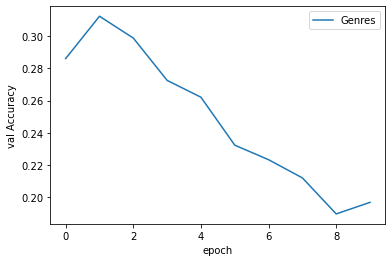

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results_g, label='Genres')


In [ ]:
gru_results_g

epoch    total time    train loss      val loss  train Accuracy  \
0      0   5233.760454  36137.559711  36137.559711        0.225051   
1      1   9049.330759  32061.998938  32061.998938        0.316240   
2      2  12788.068172  28933.592065  28933.592065        0.382018   
3      3  16600.767063  26590.954535  26590.954535        0.419826   
4      4  20437.123995  24642.444646  24642.444646        0.449898   
5      5  23881.277689  23063.280193  23063.280193        0.472182   
6      6  26976.577324  21870.732083  21870.732083        0.484324   
7      7  30102.052695  20706.086409  20706.086409        0.494211   
8      8  33314.503727  19865.689465  19865.689465        0.501793   
9      9  36492.269338  19068.242569  19068.242569        0.510297   

   val Accuracy  
0      0.286007  
1      0.312231  
2      0.298709  
3      0.272485  
4      0.262036  
5      0.232329  
6      0.223315  
7      0.212047  
8      0.189715  
9      0.196886

## 2. Book Cover Data

### 2.1 Download the Data

In [ ]:
download_url = 'https://github.com/uchidalab/book-dataset/raw/master/Task2/book32-listing.csv'
!wget $download_url

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
#adapted from https://github.com/uchidalab/book-dataset/tree/master/scripts

csv_filepath = 'book32-listing.csv'
output_dirpath = 'covers'

header_names = ['Amazon ID (ASIN)', 'Filename', 'Image URL', 'Title', 'Author', 'Category ID',
                'Category']
with codecs.open(csv_filepath, mode='r', encoding='utf-8', errors='ignore') as f:
    csv = pd.read_csv(f, delimiter=",", header=None, names=header_names)

if not os.path.isdir(output_dirpath):
    os.makedirs(output_dirpath)

def download_image(i):
    filename = csv.iloc[i]['Filename']
    category = csv.iloc[i]['Category']
    inner_output_dirpath = os.path.join(output_dirpath, category)
    if not os.path.isdir(inner_output_dirpath):
        os.mkdir(inner_output_dirpath)
    output_filepath = os.path.join(inner_output_dirpath, filename)

    url = csv.iloc[i]['Image URL']
    if not os.path.isfile(output_filepath):
        downloaded_img = request.urlopen(url)
        f = open(output_filepath, mode='wb')
        f.write(downloaded_img.read())
        downloaded_img.close()
        f.close()

def download_all_images():
    print('[Download images into "{}"]'.format(args.output_dirpath))
    Parallel(n_jobs=-1)(delayed(download_image)(i) for i in trange(len(csv)))

FileNotFoundError: ignored

In [ ]:
cover_cols = ['Amazon ID (ASIN)', 'Filename', 'Image URL', 'Title', 'Author', 'Category ID','Category']
books_cover = pd.read_csv(csv_filepath, header=None, names=cover_cols, encoding='latin1', error_bad_lines=False)
books_cover.head()

Amazon ID (ASIN)        Filename  ... Category ID   Category
0        761183272  0761183272.jpg  ...           3  Calendars
1       1623439671  1623439671.jpg  ...           3  Calendars
2       B00O80WC6I  B00O80WC6I.jpg  ...           3  Calendars
3        761182187  0761182187.jpg  ...           3  Calendars
4       1578052084  1578052084.jpg  ...           3  Calendars

[5 rows x 7 columns]

In [ ]:
books_cover.describe()

Category ID
count  207572.000000
mean       14.491680
std         9.069057
min         0.000000
25%         7.000000
50%        13.000000
75%        23.000000
max        31.000000

In [ ]:
# what is the shape of our data?
books_cover.shape

(207572, 7)

We successfully downloaded the data! We have 7 columns and 207572 rows.

### 2.2 Clean the Data

#### 2.2.1 What do our categories look like?

In [ ]:
books_cover['Category'].value_counts()

Travel                          18338
Children's Books                13605
Medical Books                   12086
Health, Fitness & Dieting       11886
Business & Money                 9965
Crafts, Hobbies & Home           9934
Science & Math                   9276
Christian Books & Bibles         9139
Cookbooks, Food & Wine           8802
Computers & Technology           7979
Literature & Fiction             7580
Religion & Spirituality          7559
Teen & Young Adult               7489
Law                              7314
Humor & Entertainment            6896
History                          6807
Arts & Photography               6460
Sports & Outdoors                5968
Romance                          4291
Biographies & Memoirs            4261
Science Fiction & Fantasy        3800
Politics & Social Sciences       3402
Reference                        3268
Comics & Graphic Novels          3026
Test Preparation                 2906
Self-Help                        2703
Engineering 

#### 2.2.2 Category mapping file
I'm going to export the dataframe as a csv, do the mappings in excel, and the bring the new csv file back in, which I'll use as the final dataframe.

In [ ]:
# export file to csv
books_cover.to_csv('book_cover.csv')

Bring in file when running in google colab through local runtime

*These are the mappings I used. I did my best to get the categories in a similar count range and this is an area that could use some improvement.*

**Help Books:** Arts & Photographs, Cookbooks & Food & Wine, Crafts & Hobbies & Home, Education & Teaching, Parenting & Relationships, Self-Help, Test Preparation

**Literary Fiction:** Gay & Lesbian, Literature & Fiction, Mystery & Thriller & Suspense, Romance, Science Fiction & Fantasy, Teen & Young Adult

**Non-Fiction:** Biographies & Memoirs, Business & Money, History, Law, Politics & Social Sciences, Reference

**Other:** Calendars, Children's Books, Comics & Graphic Novels, Humor & Entertainment

**Outdoorsy:** Health & Fitness & Dieting, Sports & Outdoors, Travel

**Religious:** Christian Books & Bibles, Religion & Spirtuality

**Technical:** Computers & Technology, Engineering & Transportation, Medical Books, Science & Math

In [ ]:
books_cover_new = pd.read_csv(r'C:\Users\Ethan\PycharmProjects\DowloadCapstoneImages\books_cover.csv', encoding="ISO-8859-1")

In [ ]:
books_cover_new = books_cover_new[['Amazon ID (ASIN)', 'Filename','Image URL', 'Title','Author', 'Old Category','Category']]
books_cover_new.sample(5)

Amazon ID (ASIN)        Filename  \
198229        393033090  0393033090.jpg   
44590         967089786  0967089786.jpg   
140772       068981528X  068981528X.jpg   
96829        1608681785  1608681785.jpg   
75102        1593272200  1593272200.jpg   

                                                Image URL  \
198229  http://ecx.images-amazon.com/images/I/51J01QYV...   
44590   http://ecx.images-amazon.com/images/I/51FXDhaV...   
140772  http://ecx.images-amazon.com/images/I/51py6K8i...   
96829   http://ecx.images-amazon.com/images/I/51baXGOY...   
75102   http://ecx.images-amazon.com/images/I/51--kb%2...   

                                                    Title           Author  \
198229  St. Vincent and the Grenadines: Bequia, Mustiq...      Jill Bobrow   
44590   Nourishing Traditions Deluxe Edition (The Book...     Sally Fallon   
140772        The Three Little Wolves and the Big Bad Pig  Eugene Trivizas   
96829        Wild Mind: A Field Guide to the Human Psyche     Bill Plotkin   
75102   The Linux Programming Interface: A Linux and U...  Michael Kerrisk   

                      Old Category     Category  
198229                      Travel    Outdoorsy  
44590       Cookbooks, Food & Wine   Help Books  
140772  Politics & Social Sciences  Non-Fiction  
96829               Science & Math    Technical  
75102       Computers & Technology    Technical

In [ ]:
# what is the new shape of our data?
books_cover_new.shape

(207572, 7)

In [ ]:
# what is the count for each cateogry? Amazon ID is a unique value, so I'll use that for counts
books_cover_new[['Category','Amazon ID (ASIN)']].groupby(['Category']).count()

Amazon ID (ASIN)
Category                          
Help Books                   34992
Literary Fiction             26497
Non-Fiction                  35017
Other                        26163
Outdoorsy                    36192
Religious                    16698
Technical                    32013

#### 2.2.3 Rest of the Data Cleaning

In [ ]:
cover_data = books_cover_new.copy()

# drop null values
cover_data = cover_data.dropna()

### 2.3 Neural Networks
- Building Model
- Simple CNN

#### 2.3.1 Building Model

Need to download the images now. I'll be using 5,000 images from each category.

In [ ]:
covers_help = cover_data[cover_data['Category']=='Help Books'].sample(5000)
covers_lit_fic = cover_data[cover_data['Category']=='Literary Fiction'].sample(5000)
covers_non_fic = cover_data[cover_data['Category']=='Non-Fiction'].sample(5000)
covers_other = cover_data[cover_data['Category']=='Other'].sample(5000)
covers_out = cover_data[cover_data['Category']=='Outdoorsy'].sample(5000)
covers_rel = cover_data[cover_data['Category']=='Religious'].sample(5000)
covers_tech = cover_data[cover_data['Category']=='Technical'].sample(5000)

cover_data = pd.concat([covers_help, covers_lit_fic, covers_non_fic, covers_other, covers_out, covers_rel, covers_tech])

cover_data

Amazon ID (ASIN)        Filename  \
42601       1495363112  1495363112.jpg   
61268        789754320  0789754320.jpg   
45090       098496312X  098496312X.jpg   
62689        996206701  0996206701.jpg   
43224        848743539  0848743539.jpg   
...                ...             ...   
72554       1118024400  1118024400.jpg   
98555        691018545  0691018545.jpg   
90612        521198577  0521198577.jpg   
84672       1284044793  1284044793.jpg   
74666       161438360X  161438360X.jpg   

                                               Image URL  \
42601  http://ecx.images-amazon.com/images/I/513pRqpZ...   
61268  http://ecx.images-amazon.com/images/I/51Cq68-d...   
45090  http://ecx.images-amazon.com/images/I/513zgkSR...   
62689  http://ecx.images-amazon.com/images/I/510s6btm...   
43224  http://ecx.images-amazon.com/images/I/61mwKWYs...   
...                                                  ...   
72554  http://ecx.images-amazon.com/images/I/51cFwA-T...   
98555  http://ecx.images-amazon.com/images/I/41jwcFy4...   
90612  http://ecx.images-amazon.com/images/I/31kl8oTZ...   
84672  http://ecx.images-amazon.com/images/I/51ZLLqlg...   
74666  http://ecx.images-amazon.com/images/I/41JDk3fc...   

                                                   Title  \
42601  Paleo Pressure Cooking!: 45 Easy, Delicious, H...   
61268                                  My Photos for Mac   
45090               The Dolce Diet: Living Lean Cookbook   
62689  A Parent's Survival Guide to College and Finan...   
43224  Southern Living Soups, Stews and Chilis: Comfo...   
...                                                  ...   
72554                           AutoCAD 2012 For Dummies   
98555                            On War, Indexed Edition   
90612            The Cambridge Guide to the Solar System   
84672                            Pharmacology For Nurses   
74666                  iPad Apps in One Hour for Lawyers   

                                        Author            Old Category  \
42601                        Andrea Huffington  Cookbooks, Food & Wine   
61268                         Michael Grothaus      Arts & Photography   
45090                            Michael Dolce  Cookbooks, Food & Wine   
62689                             Jim Trimboli    Education & Teaching   
43224  The Editors of Southern Living Magazine  Cookbooks, Food & Wine   
...                                        ...                     ...   
72554                             David Byrnes  Computers & Technology   
98555                      Carl von Clausewitz          Science & Math   
90612                          Kenneth R. Lang          Science & Math   
84672                          Blaine T. Smith           Medical Books   
74666                              Tom Mighell  Computers & Technology   

         Category  
42601  Help Books  
61268  Help Books  
45090  Help Books  
62689  Help Books  
43224  Help Books  
...           ...  
72554   Technical  
98555   Technical  
90612   Technical  
84672   Technical  
74666   Technical  

[35000 rows x 7 columns]

In [ ]:
cover_data.describe()

Amazon ID (ASIN)        Filename  \
count             35000           35000   
unique            35000           35000   
top          1569000654  0415444616.jpg   
freq                  1               1   

                                                Image URL   Title  \
count                                               35000   35000   
unique                                              34983   34886   
top     http://ecx.images-amazon.com/images/I/31VMk1dU...  Fondue   
freq                                                    6       3   

               Author              Old Category     Category  
count           35000                     35000        35000  
unique          28034                        32            7  
top     Lonely Planet  Christian Books & Bibles  Non-Fiction  
freq               70                      2722         5000

Resize all of the images to 150x150.

In [ ]:
base_dir = r'C:\Users\Ethan\Desktop\covers'

In [ ]:
import os
from PIL import Image

# do it for the help books
for file in os.listdir(base_dir+r'\Help Books'):
    image = Image.open(base_dir+r'\Help Books\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Help Books\\'+file)

In [ ]:
# check to see if it worked
image = Image.open(base_dir+r'\Help Books\0002553481.jpg')
image.size

(150, 150)

In [ ]:
# do it for the Literary Fiction books
for file in os.listdir(base_dir+r'\Literary Fiction'):
    image = Image.open(base_dir+r'\Literary Fiction\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Literary Fiction\\'+file)

# do it for the Non-Fiction books
for file in os.listdir(base_dir+r'\Non-Fiction'):
    image = Image.open(base_dir+r'\Non-Fiction\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Non-Fiction\\'+file)

# do it for the Other books
for file in os.listdir(base_dir+r'\Other'):
    image = Image.open(base_dir+r'\Other\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Other\\'+file)

# do it for the Outdoorsy books
for file in os.listdir(base_dir+r'\Outdoorsy'):
    image = Image.open(base_dir+r'\Outdoorsy\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Outdoorsy\\'+file)

# do it for the Religious books
for file in os.listdir(base_dir+r'\Religious'):
    image = Image.open(base_dir+r'\Religious\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Religious\\'+file)


# do it for the Technical books
for file in os.listdir(base_dir+r'\Technical'):
    image = Image.open(base_dir+r'\Technical\\'+file).convert('RGB')
    image = image.resize((150,150))
    image.save(base_dir+r'\Technical\\'+file)

Split into training and testing datasets.

In [ ]:
# Code adapted from: https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

import shutil
import random

base_dir = r'C:\Users\Ethan\Desktop\covers'
classes = [r'\Help Books',r'\Literary Fiction', r'\Other', r'\Non-Fiction',r'\Outdoorsy', r'\Religious',r'\Technical']

test_ratio = .20

for cls in classes:
  if not os.path.exists(base_dir+r"\train"+cls):
    os.makedirs(base_dir + r"\train" + cls)
  
  if not os.path.exists(base_dir + r"\test" + cls):
    os.makedirs(base_dir + r"\test" + cls)

  src = base_dir + cls

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(1-test_ratio))])

  train_FileNames = [src+"\\"+name for name in train_FileNames.tolist()]
  test_FileNames = [src+"\\"+name for name in test_FileNames.tolist()]

  print("*****************************")
  print(cls)
  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Testing: ', len(test_FileNames))
  print("*****************************")


  for name in train_FileNames:
    shutil.copy(name, base_dir + r'\train\\' + cls+r'\\')

  for name in test_FileNames:
    shutil.copy(name, base_dir + r'\test\\' + cls+r'\\')

  print("Copying Done!\n")

*****************************
\Help Books
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!

*****************************
\Literary Fiction
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!

*****************************
\Other
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!

*****************************
\Non-Fiction
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!

*****************************
\Outdoorsy
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!

*****************************
\Religious
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!

*****************************
\Technical
Total images:  5000
Training:  4000
Testing:  1000
*****************************
Copying Done!



In [ ]:
# Next 2 lines of code adapted from: https://towardsdatascience.com/building-a-convolutional-neural-network-for-image-classification-with-tensorflow-f1f2f56bd83b

base_dir = r'C:\Users\Ethan\Desktop\covers'
train_dir = base_dir + r'\train\\'
test_dir = base_dir + r'\test\\'

# Directory with our training pictures
train_help_books_dir = os.path.join(train_dir, r'Help Books')
train_lit_fic_dir = os.path.join(train_dir, r'Literary Fiction')
train_other_dir = os.path.join(train_dir, r'Other')
train_non_fic_dir = os.path.join(train_dir, r'Non-Fiction')
train_out_dir = os.path.join(train_dir, r'Outdoorsy')
train_rel_dir = os.path.join(train_dir, r'Religious')
train_tech_dir = os.path.join(train_dir, r'Technical')

# Directory with our testing pictures
test_help_books_dir = os.path.join(test_dir, r'Help Books')
test_lit_fic_dir = os.path.join(test_dir, r'Literary Fiction')
test_other_dir = os.path.join(test_dir, r'Other')
test_non_fic_dir = os.path.join(test_dir, r'Non-Fiction')
test_out_dir = os.path.join(test_dir, r'Outdoorsy')
test_rel_dir = os.path.join(train_dir, r'Religious')
test_tech_dir = os.path.join(train_dir, r'Technical')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./225.
train_datagen = ImageDataGenerator(rescale = 1.0/225.)
test_datagen = ImageDataGenerator(rescale = 1.0/225.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (150,150))

# Flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir, batch_size = 20, class_mode = 'categorical', target_size = (150,150))

Found 33637 images belonging to 7 classes.
Found 12637 images belonging to 7 classes.


#### 2.3.2 Build Simple CNN

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(7, activation='sigmoid')
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001), loss="binary_crossentropy",metrics=['acc'])

c:\users\ethan\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [ ]:
# code adapted from: https://towardsdatascience.com/building-a-convolutional-neural-network-for-image-classification-with-tensorflow-f1f2f56bd83b
history = model.fit_generator(train_generator, validation_data=test_generator, steps_per_epoch=100,epochs=20, validation_steps=50, verbose=1)

Epoch 1/20
100/100 [==============================] - 23s 231ms/step - loss: 0.3867 - acc: 0.2895 - val_loss: 0.3797 - val_acc: 0.3040
Epoch 2/20
100/100 [==============================] - 23s 231ms/step - loss: 0.3885 - acc: 0.2820 - val_loss: 0.3843 - val_acc: 0.2960
Epoch 3/20
100/100 [==============================] - 23s 227ms/step - loss: 0.3883 - acc: 0.3055 - val_loss: 0.3884 - val_acc: 0.2830
Epoch 4/20
100/100 [==============================] - 23s 228ms/step - loss: 0.3819 - acc: 0.3120 - val_loss: 0.3767 - val_acc: 0.3230
Epoch 5/20
100/100 [==============================] - 23s 225ms/step - loss: 0.3781 - acc: 0.3175 - val_loss: 0.3770 - val_acc: 0.3210
Epoch 6/20
100/100 [==============================] - 23s 230ms/step - loss: 0.3801 - acc: 0.3025 - val_loss: 0.3849 - val_acc: 0.2970
Epoch 7/20
100/100 [==============================] - 23s 226ms/step - loss: 0.3756 - acc: 0.3255 - val_loss: 0.3693 - val_acc: 0.3550
Epoch 8/20
100/100 [==============================] - 2

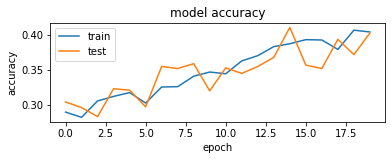

In [ ]:
 # code taken from: https://www.codesofinterest.com/2017/03/graph-model-training-history-keras.html
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history.history['acc'])  
 plt.plot(history.history['val_acc'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  

Try another CNN

In [ ]:
model_cnn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(1024, (3,3), activation="relu", input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(7, activation='sigmoid')
])

In [ ]:
model_cnn_2.compile(optimizer=RMSprop(lr=0.001), loss="binary_crossentropy",metrics=['acc'])

In [ ]:
model_cnn_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 1024)    28672     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 1024)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        589888    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9248)             

In [ ]:
# code adapted from: https://towardsdatascience.com/building-a-convolutional-neural-network-for-image-classification-with-tensorflow-f1f2f56bd83b
history_cnn_2 = model_cnn_2.fit_generator(train_generator, validation_data=test_generator, steps_per_epoch=100,epochs=20, validation_steps=50, verbose=1)

c:\users\ethan\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 465s 5s/step - loss: 0.4972 - acc: 0.1505 - val_loss: 0.4251 - val_acc: 0.1290
Epoch 2/20
100/100 [==============================] - 460s 5s/step - loss: 0.4227 - acc: 0.1520 - val_loss: 0.4162 - val_acc: 0.1390
Epoch 3/20
100/100 [==============================] - 456s 5s/step - loss: 0.4165 - acc: 0.1585 - val_loss: 0.4105 - val_acc: 0.1470
Epoch 4/20
100/100 [==============================] - 454s 5s/step - loss: 0.4134 - acc: 0.1460 - val_loss: 0.4095 - val_acc: 0.1480
Epoch 5/20
100/100 [==============================] - 452s 5s/step - loss: 0.4122 - acc: 0.1615 - val_loss: 0.4107 - val_acc: 0.1650
Epoch 6/20
100/100 [==============================] - 450s 5s/step - loss: 0.4115 - acc: 0.1510 - val_loss: 0.4125 - val_acc: 0.1360
Epoch 7/20
100/100 [==============================] - 423s 4s/step - loss: 0.4114 - acc: 0.1597 - val_loss: 0.4107 - val_acc: 0.1950
Epoch 8/20
100/100 [==============================] - 401s 4s/step - 

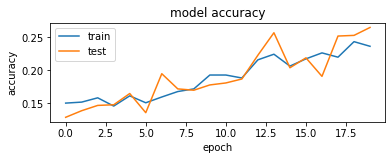

In [ ]:
 # code taken from: https://www.codesofinterest.com/2017/03/graph-model-training-history-keras.html
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history_cnn_2.history['acc'])  
 plt.plot(history_cnn_2.history['val_acc'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  